In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.distributions.utils import broadcast_all
from sparsedists.utils import mc_kl, mc_entropy
from torch.distributions.kl import kl_divergence

Let's import some densities with support over $(0, 1)$

In [2]:
from torch.distributions.uniform import Uniform
from sparsedists.exponential import RightTruncatedExponential
from sparsedists.kumaraswamy import Kumaraswamy

# Mixture of Discrete and Continuous over [0,1)

This distribution is a mixture of a point masses at $0$ and a continuous distribution over the support $(0, 1)$.

The distribution function looks like this:

\begin{equation}
f(x|\alpha, \beta) = \alpha \delta(x) + (1-\alpha) g(x|\beta) \mathbf 1_{(0, 1)}(x)
\end{equation}

where $0 < \alpha < 1$, $g(x|\beta)$ is a (properly normalised) density over $(0,1)$, and $\mathbf 1_{(0, 1)}(x)$ is the indicator function.

In [6]:
from sparsedists.mixture import MixtureD0C01

In [7]:
p = MixtureD0C01(
    probs0=torch.full([1], 0.2), 
    cont=RightTruncatedExponential(rate=torch.ones(1), upper=1.))
print(p.p0, p.pc)

tensor([0.2000]) tensor([0.8000])


In [8]:
x = p.rsample(torch.Size([10]))
x

tensor([[0.0000],
        [0.0905],
        [0.5764],
        [0.9492],
        [0.0190],
        [0.0000],
        [0.4295],
        [0.0000],
        [0.4743],
        [0.3298]])

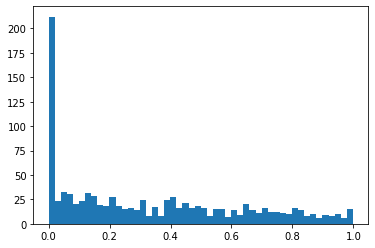

In [9]:
_= plt.hist(p.rsample(torch.Size([1000])).numpy(), bins=50)

In [10]:
p2 = MixtureD0C01(
    probs0=torch.full([1], 0.5),
    cont=RightTruncatedExponential(rate=torch.ones(1) * 1., upper=1.))
print(p2.p0, p2.pc)

tensor([0.5000]) tensor([0.5000])


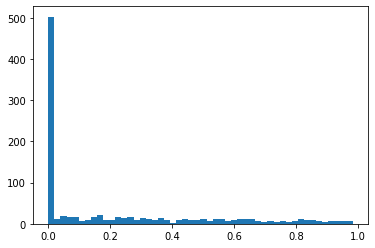

In [11]:
_= plt.hist(p2.rsample(torch.Size([1000])).numpy(), bins=50)

In [12]:
mc_kl(p, p2, 1000000)

tensor([0.1926])

In [13]:
kl_divergence(p, p2)

tensor([0.1927])

In [14]:
mc_entropy(p, 1000000)

tensor([0.4689])

In [15]:
p.entropy()

tensor([0.4679])

# Mixture of Discrete and Continuous over [0,1]

This distribution is a mixture of a point masses at $0$, another at $1$, and a continuous distribution over the support $(0, 1)$.

The distribution function looks like this:

\begin{equation}
f(x|\alpha, \beta) = \alpha_0 \delta(x) + \alpha_1 \delta(1 - x) + (1-\alpha_0-\alpha_1) g(x|\beta) \mathbf 1_{(0, 1)}(x)
\end{equation}

where $0 < \alpha_i < 1$, $g(x|\beta)$ is a (properly normalised) density over $(0,1)$, $\mathbf 1_{(0, 1)}(x)$ the indicator function.

In [18]:
from sparsedists.mixture import MixtureD01C01

In [19]:
probs = torch.from_numpy(np.array([0.3, 0.5, 0.2])).float()
probs

tensor([0.3000, 0.5000, 0.2000])

In [20]:
p = MixtureD01C01(
    cont=Uniform(torch.zeros([1]), torch.ones([1])),
    probs=probs
)

In [21]:
x = p.rsample(torch.Size([10]))
x

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.9885],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.3284],
        [0.6720]])

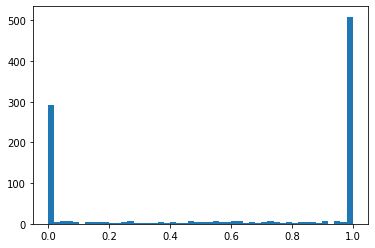

In [22]:
_= plt.hist(p.rsample(torch.Size([1000])).numpy(), bins=50)

In [23]:
q = MixtureD01C01(
    cont=Uniform(torch.zeros([1]), torch.ones([1])),
    probs=torch.from_numpy(np.array([0.2, 0.5, 0.3])).float()
)

In [24]:
p.entropy()

tensor([1.0297])

In [25]:
q.entropy()

tensor([1.0297])

In [26]:
mc_entropy(p, 1000000)

tensor([1.0290])

In [27]:
kl_divergence(p, q)

tensor([0.0405])

In [28]:
mc_kl(p, q, 1000000)

tensor([0.0402])

In [29]:
- torch.log(p.cont.cdf(1) - p.cont.cdf(0))

tensor([-0.])

# Prior and Posterior in VI

Let's specify a prior

\begin{equation}
    \alpha_0 \delta(x) + \alpha_1 \delta(1-x) + (1-\alpha_0-\alpha_1) \mathcal U(x|0, 1) \mathbf 1_{(0,1)}(x)
\end{equation}

and an approximate posterior
\begin{equation}
    \alpha_0 \delta(x) + \alpha_1 \delta(1-x) + (1-\alpha_0-\alpha_1) \text{Exp}_{(0,1)}(x|\lambda) \mathbf 1_{(0,1)}(x)
\end{equation}

where $\text{Exp}_{(0,1)}(\lambda)$ is an RightTruncatedExponential rv.

We provide support to KL for pairs like that, where the densities are mixtures D01C01 (or D0C01) and the prior uses a Uniform density over $(0, 1)$. They are particularly simple due to the uniform prior. Whenever the density used in the approximate posterior admits a closed-form entropy, we have the entire expression in closed form!

In [30]:
p = MixtureD01C01(
    cont=Uniform(torch.zeros([1]), torch.ones([1])),
    probs=torch.from_numpy(np.array([0.2, 0.5, 0.3])).float()
)

In [31]:
q1 = MixtureD01C01(
    cont=RightTruncatedExponential(rate=torch.full([1], 10.), upper=1.),
    probs=torch.from_numpy(np.array([0.3, 0.5, 0.2])).float()
)

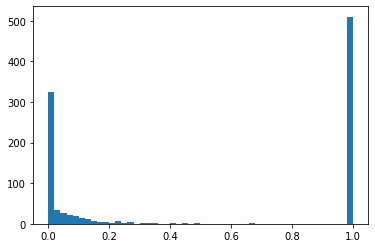

In [32]:
_= plt.hist(q1.rsample(torch.Size([1000])).numpy(), bins=50)

In [33]:
kl_divergence(q1, p)

tensor([0.3012])

In [34]:
mc_kl(q1, p, 1000000)

tensor([0.3021])

In [35]:
q1.entropy()

tensor([0.7690])

In [36]:
mc_entropy(q1, 1000000)

tensor([0.7692])

Another possible pair:

\begin{equation}
    \alpha_0 \delta(x) + \alpha_1 \delta(1-x) + (1-\alpha_0-\alpha_1) \mathcal U(x|0, 1) \mathbf 1_{(0,1)}(x)
\end{equation}

and an approximate posterior
\begin{equation}
    \alpha_0 \delta(x) + \alpha_1 \delta(1-x) + (1-\alpha_0-\alpha_1) \text{Kumaraswamy}(x|a, b) \mathbf 1_{(0,1)}(x)
\end{equation}

In [37]:
q2 = MixtureD01C01(
    cont=Kumaraswamy(a=torch.full([1], 5.), b=torch.full([1], 5.)),
    probs=torch.from_numpy(np.array([[0.3, 0.5, 0.2], [0.2, 0.5, 0.3]])).float()
)

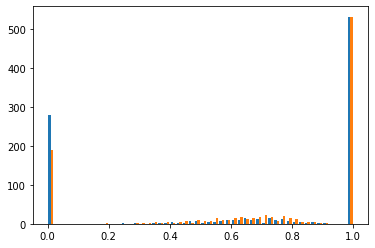

In [38]:
_= plt.hist(q2.rsample(torch.Size([1000])).numpy(), bins=50)

In [39]:
kl_divergence(q2, p)

tensor([0.1590, 0.1777])

In [40]:
mc_kl(q2, p, 1000000)

tensor([0.1631, 0.1764])

In [41]:
q2.entropy()

tensor([0.9112, 0.8520])

In [42]:
mc_entropy(q2, 1000000)

tensor([0.9074, 0.8514])